In [1]:
using OPFRecourse, Gurobi, Distributions, Plots, StatPlots

# Volatility Analysis
In this section, we look at (i) how the number of unique bases increase w.r.t the volatility of the error model, and (ii) how that affects the coverage of the model (based on number of scenarios it accounts for) when we form ensemble recourse policies based on varying numbers of bases.

In [2]:
data_file = string(Pkg.dir(),"/OPFRecourse/test/data/pglib-opf/pglib_opf_case300_ieee.m")
@time ref = [OPFRecourse.NetworkReference(data_file, σscaling=0.01*i) for i in 1:5];

  7.431996 seconds (4.65 M allocations: 265.230 MiB, 3.77% gc time)


In [3]:
srand(1234)
scenarios = [OPFRecourse.OPFScenarios(ref[i], nsamples = 10_000) for i in 1:5];

Academic license - for non-commercial use only


Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


Academic license - for non-commercial use only


Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


Academic license - for non-commercial use only


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


Academic license - for non-commercial use only


Progress:   1%|                                         |  ETA: 0:02:31WARNING: Not solved to optimality, status: Infeasible
Progress:  50%|████████████████████                     |  ETA: 0:01:08WARNING: Not solved to optimality, status: Infeasible
Progress:  68%|████████████████████████████             |  ETA: 0:00:43WARNING: Not solved to optimality, status: Infeasible
Progress:  70%|█████████████████████████████            |  ETA: 0:00:40WARNING: Not solved to optimality, status: Infeasible
Progress: 100%|█████████████████████████████████████████| Time: 0:02:15


Academic license - for non-commercial use only


Progress:   1%|█                                        |  ETA: 0:02:26WARNING: Not solved to optimality, status: Infeasible
Progress:   6%|██                                       |  ETA: 0:02:21WARNING: Not solved to optimality, status: Infeasible
Progress:   8%|███                                      |  ETA: 0:02:15WARNING: Not solved to optimality, status: Infeasible
Progress:  16%|██████                                   |  ETA: 0:02:01WARNING: Not solved to optimality, status: Infeasible
Progress:  24%|██████████                               |  ETA: 0:01:47WARNING: Not solved to optimality, status: Infeasible
Progress:  27%|███████████                              |  ETA: 0:01:42WARNING: Not solved to optimality, status: Infeasible
Progress:  28%|███████████                              |  ETA: 0:01:41WARNING: Not solved to optimality, status: Infeasible
Progress:  29%|████████████                             |  ETA: 0:01:39WARNING: Not solved to optimality, status: Infeasible



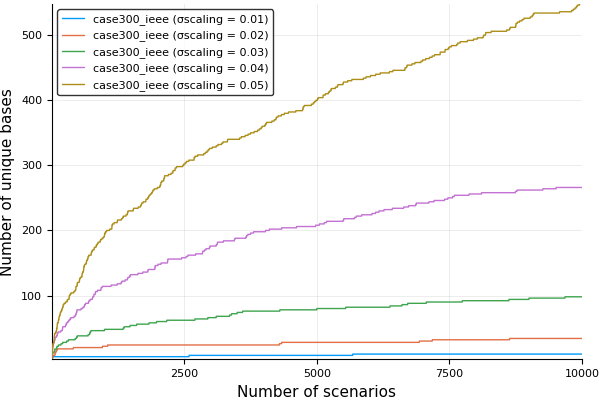

In [4]:
plot(
    [
        length(unique(scenarios[1].whichbasis[1:j,:],1))
        for j in 1:size(scenarios[1].scenarios,1)
    ],
    ylabel="Number of unique bases",
    xlabel="Number of scenarios",
    label="case300_ieee (σscaling = 0.01)"
)
for i in 2:4
    plot!(
        [
            length(unique(scenarios[i].whichbasis[1:j,:],1))
            for j in 1:size(scenarios[i].scenarios,1)
        ],
        ylabel="Number of unique bases",
        xlabel="Number of scenarios",
        label="case300_ieee (σscaling = 0.0$i)"
    )
end
plot!(
    [
        length(unique(scenarios[5].whichbasis[1:j,:],1))
        for j in 1:size(scenarios[5].scenarios,1)
    ],
    ylabel="Number of unique bases",
    xlabel="Number of scenarios",
    label="case300_ieee (σscaling = 0.05)"
)

In [5]:
function scenario_p(scenarios, i)
    uniquescenarios = unique(scenarios.whichbasis[1:i,:],1)
    [length(scenarios.whichscenario[(uniquescenarios[b,1],uniquescenarios[b,2])]) for b in 1:size(uniquescenarios,1)]
end

scenario_p (generic function with 1 method)

In [8]:
plot(
    [sum(scenario_p(scenarios[1], i)) for i in 1:size(scenarios[1].scenarios,1)] ./ size(scenarios[1].scenarios,1),
    ylabel="Proportion of Scenarios",
    xlabel="Number of Training Scenarios",
    label="case300_ieee (σscaling = 0.01)"
)
for j in 2:4
    plot!(
        [sum(scenario_p(scenarios[j], i)) for i in 1:size(scenarios[j].scenarios,1)] ./ size(scenarios[j].scenarios,1),
        ylabel="Proportion of Scenarios",
        xlabel="Number of Training Scenarios",
        label="case300_ieee (σscaling = 0.0$j)"
    )
end
plot!(
    [sum(scenario_p(scenarios[5], i)) for i in 1:size(scenarios[5].scenarios,1)] ./ size(scenarios[5].scenarios,1),
    ylabel="Proportion of Scenarios",
    xlabel="Number of Training Scenarios",
    label="case300_ieee (σscaling = 0.05)"
)


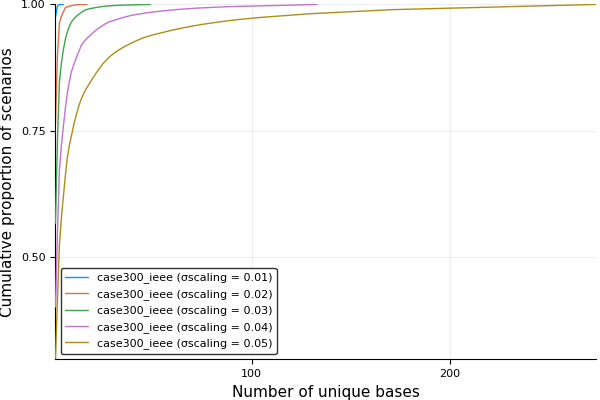

In [9]:
basiscounts = sort!(map(length, values(scenarios[1].whichscenario)), rev=true)
plot(
    cumsum(basiscounts) / sum(basiscounts),
    xlabel="Number of unique bases",
    ylabel="Cumulative proportion of scenarios",
    label="case300_ieee (σscaling = 0.01)"
)
for j in 2:4
    basiscounts = sort!(map(length, values(scenarios[j].whichscenario)), rev=true)
    plot!(
        cumsum(basiscounts) / sum(basiscounts),
        xlabel="Number of unique bases",
        ylabel="Cumulative proportion of scenarios",
        label="case300_ieee (σscaling = 0.0$j)"
    )
end
basiscounts = sort!(map(length, values(scenarios[5].whichscenario)), rev=true)
plot!(
    cumsum(basiscounts) / sum(basiscounts),
    xlabel="Number of unique bases",
    ylabel="Cumulative proportion of scenarios",
    label="case300_ieee (σscaling = 0.05)"
)

# Inspection of Solutions

In this section, we focus on understanding when the control switches between the different recourse policies. We focus on a case with 3 buses, because we can visualize that was the case with the highest volatility for which all scenarios were still feasible, to reflect a realistic operating system.

In [2]:
;cat ../test/data/pglib-opf/pglib_opf_case3_lmbd.m

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%                                                                  %%%%%
%%%%    IEEE PES Power Grid Library - Optimal Power Flow - v17.08     %%%%%
%%%%          (https://github.com/power-grid-lib/pglib-opf)           %%%%%
%%%%               Benchmark Group - Typical Operations               %%%%%
%%%%                        30 - August - 2017                        %%%%%
%%%%                                                                  %%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
%   The semidefinite relaxation of the OPF problem successfully solves 
%   this network with a value of 60 MVA for the line-flow limit on the line from
%   bus 2 to bus 3. The semidefinite relaxation fails to give a physically
%   meaningful solution to this network with a value of 50 MVA for the line-flow
%   limit on this line. See the following publication for further details.
%
%   

In [3]:
data_file = string(Pkg.dir(),"/OPFRecourse/test/data/pglib-opf/pglib_opf_case3_lmbd.m")

"/Users/yeesian/.julia/v0.6/OPFRecourse/test/data/pglib-opf/pglib_opf_case3_lmbd.m"

In [4]:
@time ref = NetworkReference(data_file, σscaling=0.4);

  8.184117 seconds (3.83 M allocations: 208.569 MiB, 3.36% gc time)


In [5]:
srand(1234)
scenarios = OPFScenarios(ref, nsamples = 10_000);

Academic license - for non-commercial use only


Progress:   0%|                                         |  ETA: 5:42:11WARNING: Not solved to optimality, status: Infeasible
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


We can see that two different optimal bases are hit by the scenarios:

In [6]:
scenarios.whichscenario

Dict{Tuple{Int64,Int64},Array{Int64,1}} with 2 entries:
  (2, 2) => [24, 39, 41, 45, 61, 139, 158, 188, 225, 282  …  9650, 9670, 9707, …
  (1, 1) => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9986, 9987, 9988, 9989, 9990, 99…

By counting the number of scenarios corresponding to each basis, we can see that `basis 1` is optimal for the vast majority of the scenarios

In [7]:
map(length,values(scenarios.whichscenario))

2-element Array{Int64,1}:
  334
 9661

Let's do a scatterplot of the scenarios that corresponds to each basis:


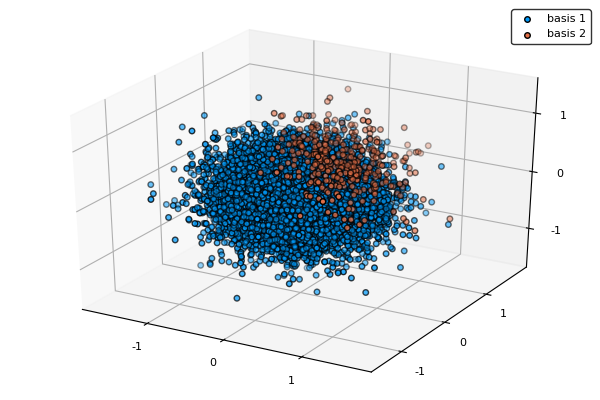

In [8]:
scatter3d(
    scenarios.scenarios[scenarios.whichscenario[(1,1)],1],
    scenarios.scenarios[scenarios.whichscenario[(1,1)],2],
    scenarios.scenarios[scenarios.whichscenario[(1,1)],3],
    label="basis 1"
)
scatter3d!(
    scenarios.scenarios[scenarios.whichscenario[(2,2)],1],
    scenarios.scenarios[scenarios.whichscenario[(2,2)],2],
    scenarios.scenarios[scenarios.whichscenario[(2,2)],3],
    label="basis 2"
)

Theory tells us that the set of scenarios for which each basis is optimal will be disjoint convex polyhedra. Since there are only 2 unique optimal bases here, the set of scenarios for which they are optimal is going to be linearly separable.

It is instructive to look at the boundary conditions under which we switch from the first choice of a basis function to an alternative basis function:

In [9]:
scenarios.solutions

9995×3 Array{Float64,2}:
 1.38476   1.96828   0.0
 0.420562  1.90587   0.0
 0.889924  1.95431   0.0
 1.6878    1.94362   0.0
 1.9247    0.668274  0.0
 1.16134   1.91025   0.0
 0.408725  2.77667   0.0
 2.77529   0.92341   0.0
 2.76366   1.77453   0.0
 1.49761   1.6794    0.0
 1.81618   1.34314   0.0
 1.1282    1.77728   0.0
 1.54593   1.72608   0.0
 ⋮                      
 0.732247  1.3619    0.0
 1.73971   1.5433    0.0
 0.665552  2.18418   0.0
 1.05233   2.10882   0.0
 0.983644  1.34824   0.0
 3.365     1.88798   0.0
 2.07807   1.682     0.0
 1.13901   2.35002   0.0
 2.45691   1.78088   0.0
 2.00699   2.43748   0.0
 2.41672   2.13494   0.0
 0.743877  1.64007   0.0

We now do a scatterplot of the power generation plan for each scenario. Since generator 3 is always 0, we can exclude it from the scatterplot.

In [10]:
scatter(
    scenarios.solutions[scenarios.whichscenario[(1,1)],1],
    scenarios.solutions[scenarios.whichscenario[(1,1)],2],
    label="basis 1", alpha=0.5,
    xlabel="generator 1 (MW)", ylabel="generator 2 (MW)"
)
scatter!(
    scenarios.solutions[scenarios.whichscenario[(2,2)],1],
    scenarios.solutions[scenarios.whichscenario[(2,2)],2],
    label="basis 2", alpha=0.5
)

The scatterplot shows us that we should switch from `basis 1` to `basis 2` in those cases where using `basis 1` would result in a violation of the lower limit for generator `1`

## Chance-Constraint Formulation
We also look at how the CC-OPF (and Full CC-OPF) with affine recourse would fare here.

  1.641361 seconds (131.93 k allocations: 7.064 MiB, 1.06% gc time)
Academic license - for non-commercial use only
  0.001118 seconds (3.08 k allocations: 162.578 KiB)
Academic license - for non-commercial use only
  0.001110 seconds (3.08 k allocations: 162.578 KiB)
Academic license - for non-commercial use only
  0.001273 seconds (3.08 k allocations: 162.578 KiB)
Academic license - for non-commercial use only



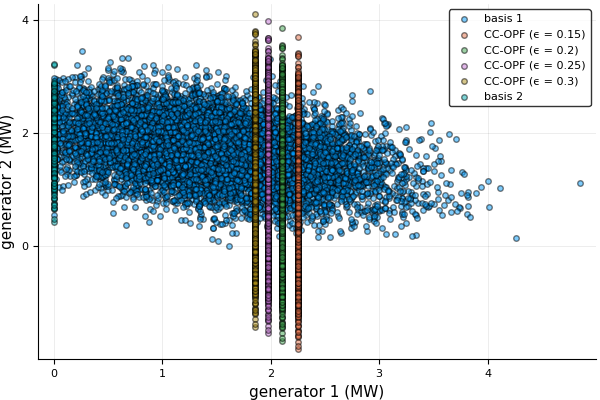

In [11]:
epsilons = collect(0.15:0.05:0.3)
ccopf = []
for ϵ in epsilons
    @time ref = NetworkReference(data_file, σscaling=0.4, bus_prob=1-ϵ, line_prob=1-ϵ);
    ccopf_ϵ = ChanceConstrainedOPF(ref, Gurobi.GurobiSolver(OutputFlag=0))
    JuMP.solve(ccopf_ϵ.model, method = :Reformulate)
    push!(ccopf, ccopf_ϵ)
end

ccopf_solutions = [
    hcat([get_opf_solution(ccopf[j], scenarios.scenarios[i,:]) for i in 1:size(scenarios.scenarios,1)]...)'
    for j in eachindex(ccopf)
]

scatter(
    scenarios.solutions[scenarios.whichscenario[(1,1)],1],
    scenarios.solutions[scenarios.whichscenario[(1,1)],2],
    label="basis 1", alpha=0.5,
    xlabel="generator 1 (MW)", ylabel="generator 2 (MW)"
)
for j in eachindex(ccopf_solutions)
    scatter!(
        ccopf_solutions[j][:,1],
        ccopf_solutions[j][:,2],
        label="CC-OPF (ϵ = $(epsilons[j]))", alpha=0.5,
    )
end
scatter!(
    scenarios.solutions[scenarios.whichscenario[(2,2)],1],
    scenarios.solutions[scenarios.whichscenario[(2,2)],2],
    label="basis 2", alpha=0.5
)

We can see that the aggregated recourse policy restricts the set of possible solutions (for any given recourse policy) to a 1-dimensional space, and it recommends using generator 2 to do the power balance, while fixing generator 1 to fixed values: as it becomes more conservative in ensuring that the constraints are satisfied, it shifts more of the power generation onto generator 1.

Switching our attention to chance constraint OPF with full affine recourse:

In [12]:
epsilons = [0.05,0.25]
ccopf = []
for ϵ in epsilons
    @time ref = NetworkReference(data_file, σscaling=0.4, bus_prob=1-ϵ, line_prob=1-ϵ);
    ccopf_ϵ = FullChanceConstrainedOPF(ref, Gurobi.GurobiSolver(OutputFlag=0))
    JuMP.solve(ccopf_ϵ.model, method = :Reformulate)
    push!(ccopf, ccopf_ϵ)
end

ccopf_solutions = [
    hcat([get_opf_solution(ccopf[j], scenarios.scenarios[i,:]) for i in 1:size(scenarios.scenarios,1)]...)'
    for j in eachindex(ccopf)
]

scatter(
    ccopf_solutions[1][:,1],
    ccopf_solutions[1][:,2],
    label="CC-OPF (ϵ = $(epsilons[1]))", alpha=0.3,
    xlabel="generator 1 (MW)", ylabel="generator 2 (MW)"
)

scatter!(
    ccopf_solutions[2][:,1],
    ccopf_solutions[2][:,2],
    label="CC-OPF (ϵ = $(epsilons[2]))", alpha=0.3,
)

  0.001052 seconds (3.08 k allocations: 162.578 KiB)
Academic license - for non-commercial use only
  0.001050 seconds (3.08 k allocations: 162.578 KiB)
Academic license - for non-commercial use only


In this case, we can see that the distribution of solutions under the CC-OPF with full affine recourse has an additional degree of freedom, and is able to capture the required variation in the optimal power generation better than the restricted CC-OPF. However, since it is only restricted to linear recourse policies, it has to balance between lowering the cost of generation while still maintaining its probabilistic guarantee: as it becomes more conservative in ensuring that the constraints are satisfied, it shifts more of the power generation onto generator 1, which is 4 times as expensive as generator 2.

# Performance Comparison
In this section, we perform an analysis of how the (i) generation cost and (ii) transmission violations vary with the number of basis functions that we take into account.

In [13]:
data_file = string(Pkg.dir(),"/OPFRecourse/test/data/pglib-opf/pglib_opf_case300_ieee.m")
@time ref = OPFRecourse.NetworkReference(data_file, σscaling=0.04);

  0.046859 seconds (157.92 k allocations: 11.059 MiB)


In [25]:
m = SingleScenarioOPF(ref, Gurobi.GurobiSolver(OutputFlag=0))

srand(1234)
scenarios = OPFRecourse.OPFScenarios(ref, m, nsamples = 10_000);

Academic license - for non-commercial use only


Progress:  18%|████████                                 |  ETA: 0:01:42WARNING: Not solved to optimality, status: Infeasible
Progress:  46%|███████████████████                      |  ETA: 0:01:07WARNING: Not solved to optimality, status: Infeasible
Progress:  54%|██████████████████████                   |  ETA: 0:00:57WARNING: Not solved to optimality, status: Infeasible
Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


In [26]:
sortedbases = sort(
    collect(keys(scenarios.whichscenario)),
    by = b -> length(scenarios.whichscenario[b]),
    rev=true
)

136-element Array{Tuple{Int64,Int64},1}:
 (20, 1) 
 (20, 8) 
 (66, 5) 
 (66, 55)
 (8, 64) 
 (85, 31)
 (35, 8) 
 (8, 52) 
 (6, 1)  
 (70, 46)
 (85, 44)
 (86, 5) 
 (68, 55)
 ⋮       
 (95, 51)
 (60, 13)
 (67, 30)
 (17, 69)
 (90, 53)
 (71, 15)
 (65, 30)
 (26, 36)
 (81, 15)
 (70, 68)
 (89, 45)
 (81, 67)

In [27]:
length(scenarios.whichscenario[(20,1)])

4030

In [28]:
length(scenarios.whichscenario[(81,67)])

1

In [35]:
br = [BasisRecourse(ref, m, scenarios.cbases[b1],scenarios.rbases[b2]) for (b1,b2) in sortedbases];

In [82]:
ensemble = EnsembleRecourse(ref, br[1], br[2:5]);
@time solns = [get_opf_solution(ensemble, scenarios.scenarios[(j-1)*10 + i,:]) for i in 1:10, j in 1:30]
results = DataFrames.DataFrame(Dict(
    :meancost => [
        mean(cost(ref, solns[i,j]) for i in 1:10)
        for j in 1:30
    ],
    :nviolations => [
        mean(ntransmissionviolations(ref, solns[i,j], scenarios.scenarios[(j-1)*10 + i,:]) for i in 1:10)
        for j in 1:30
    ],
    :nbasis => fill(5, 30)
))

for nbasis in 10:5:25
    ensemble = EnsembleRecourse(ref, br[1], br[2:nbasis]);
    @time solns = [get_opf_solution(ensemble, scenarios.scenarios[(j-1)*10 + i,:]) for i in 1:10, j in 1:30]
    results = vcat(results, DataFrames.DataFrame(Dict(
        :meancost => [
            mean(cost(ref, solns[i,j]) for i in 1:10)
            for j in 1:30
        ],
        :nviolations => [
            mean(ntransmissionviolations(ref, solns[i,j], scenarios.scenarios[(j-1)*10 + i,:]) for i in 1:10)
            for j in 1:30
        ],
        :nbasis => fill(nbasis, 30)
    )))
end

boxplot(results, :nbasis, :meancost)

 20.448233 seconds (345.89 M allocations: 6.471 GiB, 10.71% gc time)
 38.998894 seconds (691.76 M allocations: 12.940 GiB, 11.08% gc time)
 64.445189 seconds (1.04 G allocations: 19.408 GiB, 10.52% gc time)
 76.432595 seconds (1.38 G allocations: 25.877 GiB, 11.30% gc time)
100.244565 seconds (1.73 G allocations: 32.346 GiB, 11.46% gc time)


In [83]:
boxplot(results, :nbasis, :nviolations)